In previous years, we exclusively used the open source software Cytoscape for the analysis of complex networks.
Although the platform is an extremely powerful tool for working with networks, dealing
with networks programmatically can often be more useful. 
Last year, we decided to replace most of its use with NetworkX.
NetworkX is a commonly used Python package for analyzing and visualizing networks and is more effective than Cytoscape when it comes to network generation and manipulation.
The documentation can be found [here](https://networkx.org/documentation/stable/index.html), along with a description of the installation procedure and a tutorial guide to help you get started with the library.
For network visualization, we will be using the [pyvis](https://pyvis.readthedocs.io/en/latest/) library.
You will also be needing other third-party Python packages with additional functionality when working with the projects (e.opt_g. [NumPy](https://numpy.org/doc/stable/reference/index.html#reference), [SciPy](https://scipy.github.io/devdocs/reference/index.html#scipy-api), [pandas](https://pandas.pydata.org/docs/reference/index.html#api), [Matplotlib](https://matplotlib.org/stable/api/index.html)).

If you run into any issues or have questions that needs addressing, please create a post on the [Blackboard Discussion Board 'Project Q&A'](https://ntnu.blackboard.com/webapps/blackboard/content/launchLink.jsp?course_id=_32029_1&content_id=_1593799_1&mode=cpview) or contact me via email (vetle.simensen@ntnu.no).
I'd prefer the former as it allows other students to help out, as well as making the answers available to everyone. 

### 1.1 LOTR social interaction network

In order to get familiar with NetworkX, we will begin by importing and inspecting the social interaction network from the Lord of the Rings (LOTR) novels.
Download the LOTR social interaction network found on Blackboard `LOTR_network.txt` (edge list format). 
Here, a link between two characters (named in column one and two) corresponds to either a physical interaction or conversation in the novels. 
The third column contains an edge attribute that denote the number of times the character pair interacted.

(i) Import and construct the LOTR social interaction network using NetworkX.

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
from pyvis.network import Network
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Change working directory (My computer):
import os 

if os.name == "nt":
    os.chdir("c:/Users/Legion/Documents/SystemsBiology2/SystemsBiology2/")
elif os.name == "posix":
    os.chdir("/home/klementinsen/TBT4165/project1")


In [3]:
# NB! This df will have each edge noted twice. I.e. A - B and B - A. 
df = pd.read_csv("LOTR_network.txt", header=None, delim_whitespace=True)
df.columns = ["source", "target", "n_int"]

# Generate the graph:
opt_g = nx.from_pandas_edgelist(df, "source", "target", edge_attr=True)

# A dictionary with keys as a tuple of the two names, and the value as its
# own dictionary with "n_int" as key and the value as # of interactions:
w_data = nx.get_edge_attributes(opt_g, "n_int")  # This line removes the "double" notation problem

# Generate an optimal dictionary with the sorted names of the pair as key, 
# and # of interactions as value:
opt_d = {"-".join(sorted([key[0],key[1]]))  # 1. Sort the tuple (i.e. the key). 2. Join the names to a string
         : 
         value for key,value in w_data.items()
         }

# Sort the dict by value:
opt_d = {key: val for key, val in sorted(opt_d.items(), key = lambda ele: ele[1], reverse=True)} # From: https://www.geeksforgeeks.org/python-sort-a-dictionary/ 

# Generate an optimal data frame:
opt_df = pd.DataFrame({
    "pair" : opt_d.keys(),
    "n_int" : opt_d.values()
}).sort_values(by=["n_int"], ascending=False) # Sort the data frame by n_int value

(ii) What is the number of nodes and edges in this network?

In [4]:
N = opt_g.number_of_nodes()
E = opt_g.number_of_edges()
print(f"The number of nodes in the network is {N}")
print(f"The number of edges in the network is {E}") 

# Number of neighbors:
# NN = 2*E

The number of nodes in the network is 90
The number of edges in the network is 260


(iii) Which three character pairs interacted most frequently?

In [5]:
# Using pandas;
print("Answer by Pandas:", opt_df.sort_values(by=["n_int"], ascending=False).head(3), sep="\n")

# Using the edge_attribute dict gathered from NetworkX:
# The dict is already sorted by value.
print(f"\n\nAnswer by dictionary from NetworkX: {', '.join(list(opt_d.keys())[:3])}")


Answer by Pandas:
            pair  n_int
0      frodo-sam    152
1  frodo-gandalf     56
2  gimli-legolas     53


Answer by dictionary from NetworkX: frodo-sam, frodo-gandalf, gimli-legolas


(iv) Using pyvis, create a visualization of the network. From this visualization alone, what do you think the degree distribution will look like?

In [13]:
# Custom function:
def show_html(graph, name="nx", show=True, size="small", more=False):
    """
    Generate and display the graph through pyvis
    """
    in_ipynb = {"notebook":True, "cdn_resources":"remote"}
    
    if size == "small":
        s = {"height":"500px", "width":"500px"}
    else:
        s = {"height":"1080px", "width":"1920px"}
    
    if more:
        m = {"select_menu":True, "filter_menu":True}
        nt = Network(**s, **m, **in_ipynb)
        nt.show_buttons(filter_="physics")
        nt.from_nx(graph)
    else:
        nt = Network(**s, **in_ipynb)
        nt.from_nx(graph)
    
    
    if show:
        nt.show(f"{name}.html")


# Use the custom function to generate a HTML format
# of the graph:
show_html(opt_g, name="LOTR_social_network", 
          show=True, size="small", more=True)

**Text answer:**

<span style="color:blue">
I believe the degree distribution will follow the power-law function given that it is a social network. So, given that many characters only play a small part in the plot they may not have so many interactions with other characters. I.e. their node degree will be small (1 or 2). Some characters, like the main characters, does interact a lot with each other, meaning that their nodes will have a high degree. However, the main characters are truly only a handful of people.

(v) Plot and classify the node degree distribution. How does the results match your answer in (iv)?

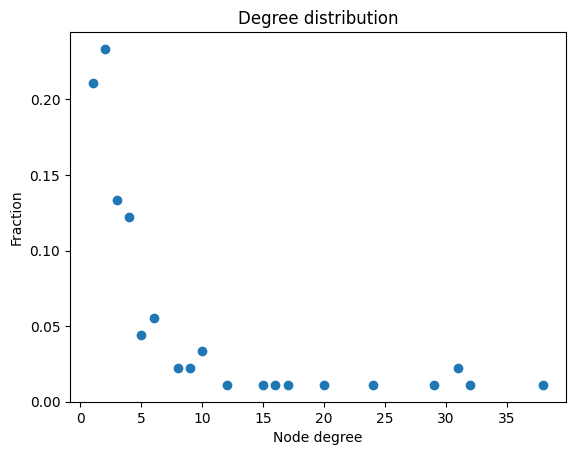

In [7]:
# Custom functions: 
def nice_plot(title, xlab, ylab, show=True):
    """
    Function to generate title and axis labels to a plot.
    The argument "show" is by default True. 
    """
    plt.title(title)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    if (show == True):
        plt.show()


def plot_degree_distribution(graph):
    """
    Function that returns a scatter plot of the degree
    distribution of a graph. 
    """
    N = graph.number_of_nodes()  # Total number of nodes
    y = np.array(nx.degree_histogram(graph))/N  # All occurrences of "n" degree, divided by total number of nodes
    x = np.arange(len(y))[y != 0]  # x values
    y = y[y != 0]  # Remove the values = 0 from the array
    
    return plt.scatter(x,y)


plot_degree_distribution(opt_g)
nice_plot("Degree distribution", "Node degree", "Fraction")


**Text answer:**

<span style="color:blue">
I think the plots show more or less the same as I argued for in the previous task

(vi) Plot and explain the histogram of number of pair-interactions. Discuss your findings.

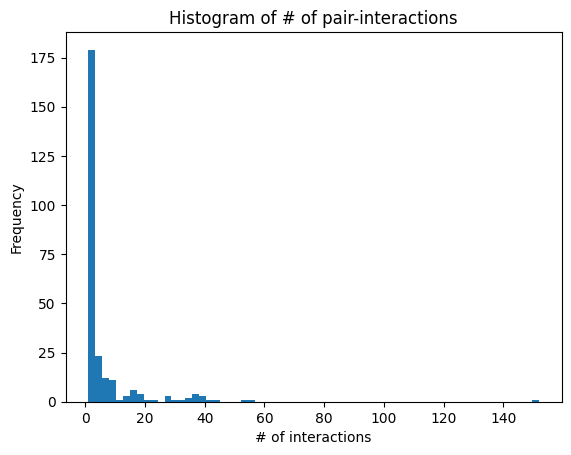

In [8]:
plt.hist(opt_d.values(), bins=round(len(opt_d.values())/4))
nice_plot("Histogram of # of pair-interactions", "# of interactions", "Frequency") 

**Text answer:**

<span style="color:blue">
From the histogram one can clearly see that out of 260 pairs almost all interaction events per pair are under 20. Moreover, all but one is less than 60, with the extreme one being interaction events between frodo and sam (the main protagonists). In practice this would mean that most characters barely interact with each other. 

(vii) Calculate the betweenness centrality (BC), closeness centrality (CC), degree, and clustering for all nodes. Identify the 5 nodes with largest BC, CC, degree, and clustering. Based on these numbers, which 2 characters will you argue to be the main characters of the story?

In [9]:
centrality_df = pd.DataFrame({
    "Node" : list(opt_g.nodes()),  # All the nodes (i.e. character names)
    "Betweenness centrality" : nx.betweenness_centrality(opt_g).values(),  # .values() to get the values from the dict
    "Closeness centrality" : nx.closeness_centrality(opt_g).values(),  # .values() to get the values from the dict
    "Degree" : dict(nx.degree(opt_g)).values(),  # Convert special nx type to dict, then .values() to get the values from the dict
    "Clustering coefficient" : nx.clustering(opt_g).values()  # .values() to get the values from the dict
})


# Custom function:
def disp(col, df):
    """
    Function that returns a string of 5 character names. 
    The string is generated from a list of 5 elements. 
    The list is generated by the sorted values of a column 
    of a data frame. 
    """
    lst = centrality_df.sort_values(by=[col], ascending=False).head(5)["Node"]  # Node is column, sorted by argument "col"
    return ", ".join(lst).format()  # Collapse the list by ", ".


print(f"""
The nodes with the largest:
Betweenness centrality: {disp("Betweenness centrality", df=centrality_df)}
Closeness centrality:   {disp("Closeness centrality", df=centrality_df)}
Degree:                 {disp("Degree", df=centrality_df)}
Clustering coefficient: {disp("Clustering coefficient", df=centrality_df)}
""")

# Display the number of nodes with clustering coefficient of 1:
# print("\nNodes with clustering coefficient of 1:", 
#       list(centrality_df[centrality_df["Clustering coefficient"] == 1]["Node"]), 
#       sep="\n")
# print("\nThat is", 
#       centrality_df[centrality_df["Clustering coefficient"] == 1]["Node"].count(),
#       "nodes.")

# centrality_df[centrality_df["Clustering coefficient"] == 1]


The nodes with the largest:
Betweenness centrality: frodo, sam, merry, gandalf, aragorn
Closeness centrality:   frodo, gandalf, merry, aragorn, pippin
Degree:                 frodo, gandalf, merry, aragorn, pippin
Clustering coefficient: bergil, bregalad, anborn, grishnakh, elladan



**Text answer:**

<span style="color:blue">
There are 4 characters that are among top 5 for all of the variables (apart clustering coefficient), Frodo, Merry, Gandalf, and Aragorn. However, I would argue that Frodo and Gandalf are the main characters of the books. Frodo because he tops all the mentioned variables. Gandalf because he have a high node degree (i.e he interacts with many different people), and because he have a high (2nd highest) closeness centrality (i.e. there are only a few nodes between Gandalf and all other nodes). One could also make an argument for Merry as one of the two main characters, as Merry have similar values as Gandalf. Merry even has a higher betweenness centrality than Gandalf, meaning that more shortest paths pass the "Merry node" than the "Gandalf node". If one knows the work of J.R.R. Tolkien this may not come as a surprise given that Merry (and Pippin) take part in an adventure of their own where they interact with several characters that the rest of the "main" characters do not meet. In this sense I recon that the betweenness centrality could lead to somewhat flawed conclusions. This because even tough a lot of shortest paths runs trough the "Merry node" it does not (necessarily) mean that the information is important for the main plot of the story (e.g. interactions with orks, ents, and inhabitants of Rohan).

<span style="color:blue">
The clustering coefficient may not be as effective to describe the importance of certain nodes, because a lot of nodes will have a clustering coefficient of 1 (here: 34 nodes). Most of these nodes have a low degree ($1 < degree < 5$), and is in my opinion not so important (verbally at least) to the main storyline. Given that this is a social network it is naturally to think that the "clusters" formed is due to a small group of 3 characters meeting in an isolated setting (e.g. the spider Shelob, Frodo, and Sam). Two characters, Treebeard and Haldir, have respectively a node degree of 6 and 5, and does in my opinion form respective "true" clusters with some of the main characters. I believe the groups meet with all members present in a particular time period of the story, and that these meetings are of (somewhat) significant to the story line.

**1.2** In the following, generate 10 examples of each network model using the [graph generators](https://networkx.org/documentation/stable/reference/generators.html) from NetworkX. Average the calculated clustering coefficient $<$C$>$, the average path length $<$L$>$, and network diameter $<$D$>$ over the 10 networks. You may find that NetworkX throws some error messages when attempting to calculate the average path length and diameter if one of the generated networks contains several disconnected components. To deal with this issue, you can either extract the giant component of the generated network before calculating the network measures, or alternatively, re-generate the network until it only contains a single connected component.

(i) Compare Erdos-Renyi (ER) networks G(n,m) with the same number of nodes (n) and edges (m) as the LOTR network. Argue why or why not G(n,m) is a good model for LOTR based on the network measures you calculated. Use the `gnm_random_graph` network generator as `erdos_renyi_graph` requires a probability p for edge creation instead of the number of edges m.

<span style="color:blue">
First I want to get some parameter values from the LOTR network, for comparison:

In [10]:
# The LOTR network is not connected. There are 3 connected components
# of the network, but the largest one (all but 4 nodes) are of most
# importance. The following codes generates this component as its
# own network:
S = [opt_g.subgraph(c).copy() for c in nx.connected_components(opt_g)]  # Get the components
S = sorted(S, key=lambda x: x.number_of_nodes(), reverse=True)  # Sort on degree
S = S[0]  # Only the largest component

print(
f"""
*** LOTR network ***
The average of the average clustering coefficient, shortest path length, and network diameter for the 10 graphs were:
Clustering coefficient: {nx.average_clustering(S)}
Path length:            {nx.average_shortest_path_length(S)}
Diameter:               {nx.diameter(S)}
"""
)


*** LOTR network ***
The average of the average clustering coefficient, shortest path length, and network diameter for the 10 graphs were:
Clustering coefficient: 0.6025883521350106
Path length:            2.516005471956224
Diameter:               6



In [11]:
# Example of ER network:
g_ER = nx.gnm_random_graph(N, E)
# Use the custom function from earlier to generate graph:
show_html(g_ER, name="Example_ER_network", show=False)


In [12]:
C, L, D = [], [], []  # Empty lists for storage
for _ in range(10):  # Iterate 10 times, i.e. generate 10 graphs
    g = nx.gnm_random_graph(N, E)  # Generate a graph
    # We want a connected graph, so generate graphs
    # until we get a connected example:
    while nx.is_connected(g) != True:  # I.e. while network is not connected
        g = nx.gnm_random_graph(N, E)  # Generate new graph

    # After the graph is ensured to be connected:
    # Append the network parameters to the respective lists:
    C.append(nx.average_clustering(g))
    L.append(nx.average_shortest_path_length(g))
    D.append(nx.diameter(g))

# Print the mean values for the 10 graphs:
print(
f"""
*** ER networks ***
The average of the average clustering coefficient, shortest path length, and network diameter for the 10 graphs were:
Clustering coefficient: {np.mean(C)}
Path length:            {np.mean(L)}
Diameter:               {np.mean(D)}
"""
)


*** ER networks ***
The average of the average clustering coefficient, shortest path length, and network diameter for the 10 graphs were:
Clustering coefficient: 0.06445879429212761
Path length:            2.7303121098626715
Diameter:               5.1



**Text answer:**

<span style="color:blue">
I do not think the Erdos-Renyi (ER) model is a good representation of a social network as the LOTR network. This is because the connectivity of each node is higher than it is in the LOTR network. I.e. there is a "typical" node, which do result in a bell-shaped connectivity distribution. This was shown not to be the case for the LOTR network.

(ii) Compare it with the Barabasi-Albert (BA) random network model. Explain which choice you make for the parameters: number of nodes (n) and minimum number of edges per node (m). Argue why or why not the BA model describes the LOTR network.

In [13]:
# Example of BA network:
g_BA = nx.barabasi_albert_graph(N, 1)
show_html(g_BA, name="Example_BA_network", show=False)

# This code chunk works in similarly as what was done
# for the BA model above:
C, L, D = [], [], []
for _ in range(10):
    g = nx.barabasi_albert_graph(N, 1)
    while nx.is_connected(g) != True:
        g = nx.barabasi_albert_graph(N, 1)

    C.append(nx.average_clustering(g))
    L.append(nx.average_shortest_path_length(g))
    D.append(nx.diameter(g))

print(
f"""
*** BA networks ***
The average of the average clustering coefficient, shortest path length, and network diameter for the 10 graphs were:
Clustering coefficient: {np.mean(C)}
Path length:            {np.mean(L)}
Diameter:               {np.mean(D)}
"""
)


*** BA networks ***
The average of the average clustering coefficient, shortest path length, and network diameter for the 10 graphs were:
Clustering coefficient: 0.0
Path length:            4.730611735330837
Diameter:               10.7



**Text answer:**

<span style="color:blue">
First, I guess that the minimum number of edges (m) per node must be at least 1 in a social network. I guess a character in a book may not interact with anyone, but then it would not make much sense to incorporate them in the social network. E.g. several characters are present in the LOTR books, but are not included in the social network because they do not speak/interact with other characters. I set the number of nodes equal to the number of nodes as the LOTR network. 

<span style="color:blue">
Secondly, no, I do not think the BA model fits the LOTR network. This because the average clustering coefficient seems to be 0, which is typical for BA networks. Moreover, the diameter of the network is much longer than for the LOTR network. 

(iii) Plot the degree distribution of one instance of each of the randomly generated ER and BA networks. Discuss and compare it to the degree distribution of the LOTR network.

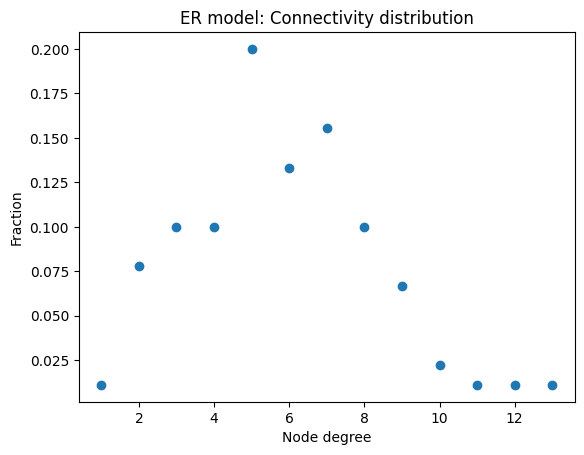

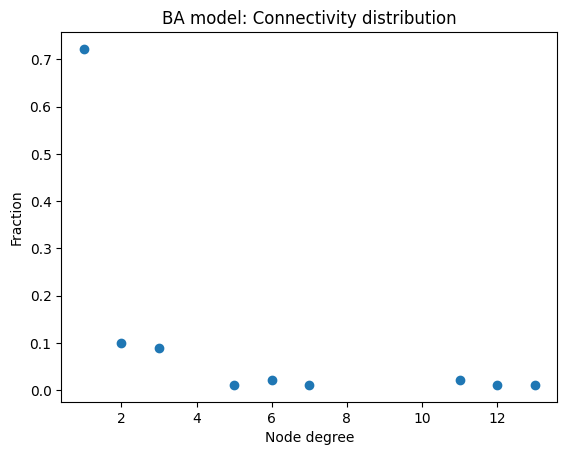

In [14]:
# Plotting the degree distribution with with a custom function:
plot_degree_distribution(g_ER)
nice_plot("ER model: Connectivity distribution", "Node degree", "Fraction")

plot_degree_distribution(g_BA)
nice_plot("BA model: Connectivity distribution", "Node degree", "Fraction")


**Text answer:**

<span style="color:blue">
The degree distribution for the ER model does as expected follow a bell-shaped curve (on average), while the BA model have a distribution more similar to the power-law function. So, the BA model is more similar to the LOTR network when it comes to degree distribution. However, in LOTR network ~20% of the nodes have a degree value of 1, while ~60% for the BA model. 

**1.3** (i) Generate 20 Watts-Strogatz (WS) networks for size n=1000, k=5, and p distributed evenly between 0.001 and 0.1.

a) Plot average shortest distance, $<$L$>$, as function of randomness p.

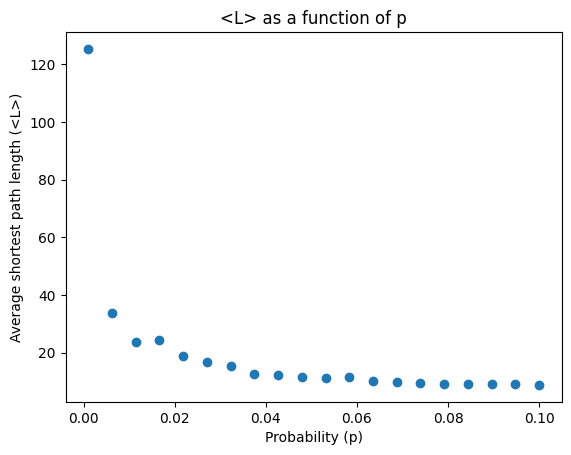

In [15]:
if "WS_dict" not in globals():  # Prevents the code from running twice. It takes a long time!
    WS_dict = {}  # Empty dict
    
    # Probability:
    p_array = np.linspace(0.001, 0.1, 20)  # Even distribution of 20 numbers
    
    for i in p_array:  # Iterate over the probabilities 
        # Generate graph with i probability: (obs! I haven't checked if it's connected)
        g = nx.watts_strogatz_graph(n=1000, k=5, p=i)
        # New dict entry with prob. i as key, and another
        # dict as value. This dict have two entries, one for
        # L (i.e. length) and one for C (i.e. clustering):
        WS_dict[i] = {
            "L" : nx.average_shortest_path_length(g),
            "C" : nx.average_clustering(g)
        }


x=list(WS_dict.keys())  # All prob. values. Could have used p_array
y_L=[WS_dict[key]["L"] for key in x]   
y_C=[WS_dict[key]["C"] for key in x]


plt.scatter(x, y_L)
nice_plot("<L> as a function of p", "Probability (p)", "Average shortest path length (<L>)")

b) Plot clustering, $<$C$>$, as function of randomness p.

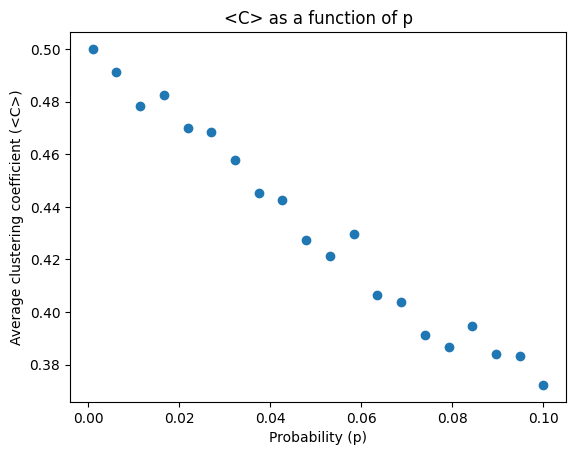

In [16]:
plt.scatter(x, y_C)
nice_plot("<C> as a function of p", "Probability (p)", "Average clustering coefficient (<C>)")


c) Comment on the observed network behavior and tie it to what you know about WS networks.

**Text answer:**

<span style="color:blue">
The average shortest path length ($<$L$>$) goes from >80 when the probability p is 0.001, however plummets until the probability is ~0.02, when $<$L$>$ is just below 20. At this point the $<$L$>$ value seems to decrease somewhat linearly at a point $<$10 for probability of 0.1. The average clustering coefficient ($<$C$>$) seems to be highly negatively linearly correlated with the probability (at lest in the probability range used). 

(ii) Generate 20 Barabasi-Albert networks for m=2 and size n distributed evenly on a log scale between 50 and 5000.

a) Plot average shortest distance, $<$L$>$, as function of number of nodes, n.

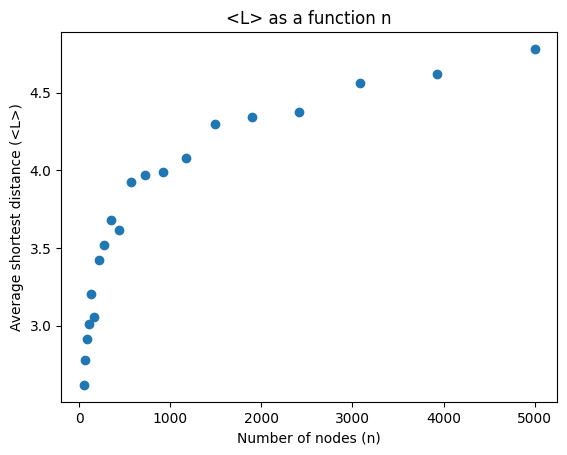

In [17]:
if "BA_dict" not in globals():  # Prevents the code from running twice. It takes a long time!
    BA_dict = {}

    # Number of nodes:
    n_array = np.logspace(
        np.log10(50), np.log10(5000), 
        base=10,
        num=20  # 20 elements in the array
        ).round()  # Number of nodes is an integer, therefore the .round(0)

    for i in n_array:
        g = nx.barabasi_albert_graph(n=i, m=2)
        BA_dict[i] = {
            "L" : nx.average_shortest_path_length(g),
            "C" : nx.average_clustering(g)
        }


x=list(BA_dict.keys())  # x values, i.e. #-nodes
y_L=[BA_dict[key]["L"] for key in x]  # y-values, i.e. <L>
y_C=[BA_dict[key]["C"] for key in x]  # y-values, i.e. <C>

plt.scatter(x, y_L)
nice_plot("<L> as a function n", "Number of nodes (n)", "Average shortest distance (<L>)")


b) Plot clustering, $<$C$>$, as function of number of number of nodes, n.

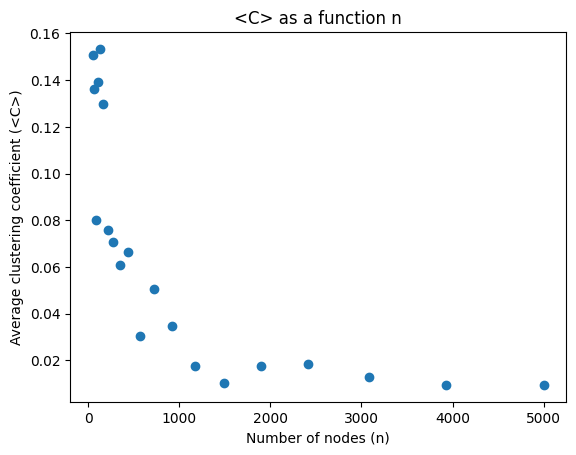

In [18]:
plt.scatter(x, y_C)
nice_plot("<C> as a function n", "Number of nodes (n)", "Average clustering coefficient (<C>)")

c) Comment on the observed network behavior and tie it to what you know about BA networks.

**Text answer:**

<span style="color:blue">
The average shortest path length ($<$L$>$) seems to have a logarithmic growth from just below 3 when the number of nodes are 50, to ~4 when the number of nodes are 1000, to just under 5 when the number of nodes are 5000. The average clustering coefficient ($<$C$>$) seems to have a more power-law function in relation to the number of nodes. 